# Measurement Correction

* **Last Updated:** Jan 24, 2019
* **Requires:** qiskit-terra 0.7

The idea behind measurement correction is to prepare all 2^n basis states and measure the probability of measuring counts in the other basis states. From these calibrations we can correct the average results of other experiment.

In [10]:
# Needed for functions
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Measurement correction functions
import sys, os
sys.path.append(os.path.abspath(os.path.join('../qiskit_ignis')))
import measurement_correction as meas_corr

## 3 Qubit Example of the Calibration Matrices

Here we will generate a calibration matrix for 3 qubits in a 5 qubit sample

In [11]:
#generate a noise model for the qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1,0.9]])
    noise_model.add_readout_error(read_err,[qi])

In [12]:
#generate the calibration circuits
qr = qiskit.QuantumRegister(5)
meas_calibs, state_labels = meas_corr.measurement_calibration_circuits([qr[2],qr[3],qr[4]])

In [13]:
#run the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
qobj = qiskit.compile(meas_calibs, backend=backend, shots=1000)
job = backend.run(qobj, noise_model=noise_model)
cal_results = job.result()

In [14]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [15]:
#make a calibration matrix
cal_matrix = meas_corr.measurement_calibration_matrix(cal_results,state_labels)
print(cal_matrix)

[[0.441 0.053 0.06  0.009 0.051 0.006 0.007 0.005]
 [0.136 0.513 0.016 0.076 0.018 0.068 0.003 0.006]
 [0.146 0.02  0.494 0.077 0.023 0.007 0.07  0.011]
 [0.039 0.173 0.161 0.596 0.011 0.021 0.024 0.094]
 [0.133 0.014 0.018 0.004 0.537 0.059 0.057 0.009]
 [0.053 0.164 0.007 0.028 0.144 0.611 0.018 0.08 ]
 [0.04  0.005 0.179 0.018 0.162 0.019 0.624 0.072]
 [0.012 0.058 0.065 0.192 0.054 0.209 0.197 0.723]]


## Correct Measurement Noise on a 3Q GHZ State

In [16]:
#make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])

qobj = qiskit.compile([ghz], backend=backend, shots=5000)
job = backend.run(qobj, noise_model=noise_model)
results = job.result()

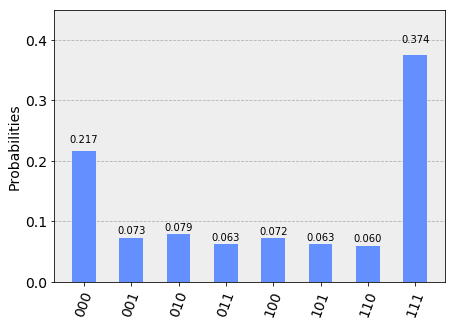

In [17]:
#results without correction
plot_histogram(results.get_counts(0))

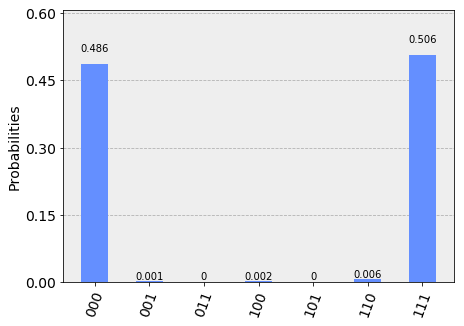

In [18]:
#results with correction
plot_histogram(meas_corr.apply_measurement_calibration(results.get_counts(0),state_labels,cal_matrix, method=1))